In [1]:
import zipfile
import os

zip_file_path = '/content/archive.zip'
# Define the directory where you want to extract the contents
extracted_dir = '/content/extracted_files'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extracted_dir)

print(f"Successfully extracted '{zip_file_path}' to '{extracted_dir}'")

Successfully extracted '/content/archive.zip' to '/content/extracted_files'


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb

In [14]:
df = pd.read_csv('/content/extracted_files/heart.csv')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [9]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [15]:
# For numerical features
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in numerical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

In [16]:
# For categorical features
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for col in categorical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

In [17]:
# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

In [18]:
# Feature scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [19]:
# Split data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split into train and test sets (80:20 as mentioned in the paper)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [20]:
# Initialize XGBoost classifier with parameters from the paper
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    random_state=55,
    objective='binary:logistic',
    eval_metric='logloss'
)


In [21]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=55, ...)

In [22]:
# Make predictions
y_pred = xgb_model.predict(X_test)

In [23]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [24]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[ 98   0]
 [  0 107]]


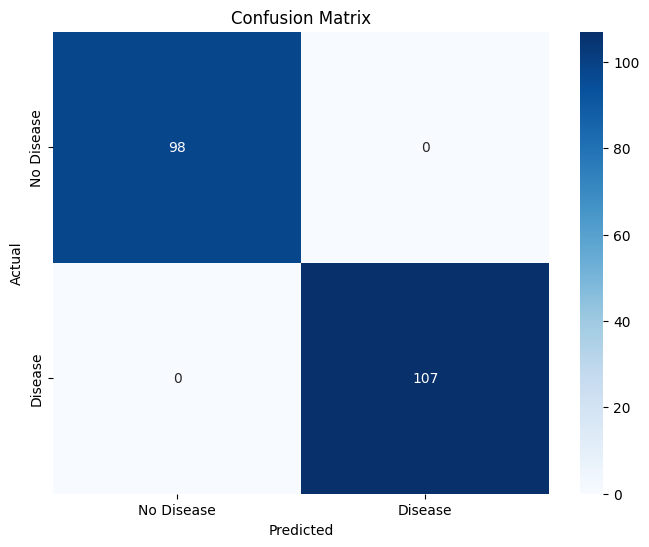

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation Scores: [0.9804878  1.         1.         0.97073171 0.98536585]
Mean CV Accuracy: 0.9873
Standard Deviation: 0.0114


In [29]:
# Save the XGBoost model in .h5 format
xgb_model.save_model('heart_disease_model.h5')

# Download to your local machine (for Google Colab/Jupyter)
from google.colab import files
files.download('heart_disease_model.h5')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:40:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# Save the XGBoost model in .h5 format
xgb_model.save_model('heart_disease_model.h5')

# Download to your local machine (for Google Colab/Jupyter)
from google.colab import files
files.download('heart_disease_model.h5')

# Get the original column names before one-hot encoding
original_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                   'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# Quick test with random values from ORIGINAL data (before one-hot encoding)
original_df = pd.read_csv('/content/extracted_files/heart.csv')
random_patient = {col: np.random.choice(original_df[col]) for col in original_columns}

# Convert to DataFrame and preprocess EXACTLY like training data
input_df = pd.DataFrame([random_patient])

# One-hot encode (must match training exactly)
input_df = pd.get_dummies(input_df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

# Ensure all columns exist (add missing with 0)
for col in X_train.columns:
    if col not in input_df.columns:
        input_df[col] = 0

# Reorder columns and scale numerical features
input_df = input_df[X_train.columns]
input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

# Make prediction
pred = xgb_model.predict(input_df)[0]
prob = xgb_model.predict_proba(input_df)[0][1]

# Print results
print(f"Random patient prediction: {'🚨 Heart Disease Detected' if pred == 1 else '✅ No Heart Disease'}")
print(f"Probability: {prob:.1%}")
print("\nPatient Details:")
for k, v in random_patient.items():
    print(f"{k:8}: {v}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random patient prediction: ✅ No Heart Disease
Probability: 1.1%

Patient Details:
age     : 46
sex     : 0
cp      : 3
trestbps: 138
chol    : 322
fbs     : 0
restecg : 0
thalach : 125
exang   : 1
oldpeak : 1.6
slope   : 2
ca      : 0
thal    : 3
